In [84]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import yfinance as yf
from datetime import datetime, timedelta
from pandas_datareader.data import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')


def pull_stock(stock, start):
    
    # read stock market data. Remove extra records that don't conform to the shape of the lag
    yf.pdr_override()
    df = pdr.data.get_data_yahoo(stock, start=start)
    #df = DataReader(stock, data_source='yahoo', start='2012-01-01', end=datetime.now())
    df_size = len(df) - len(df)%lag
    df = df.tail(df_size)
    
    return df


def data_prep(df, lag):

    scaler = MinMaxScaler(feature_range=(0,1))
    #dataset = scaler.fit_transform(df)
    dataset = df.values

    # split that data into roughly 80/20.
    training_data_len = int(np.ceil(len(dataset) * .8)-(np.ceil(len(dataset) * .8)%lag))
    test_data_len = int(len(dataset[training_data_len:])-(len(dataset[training_data_len:])%lag))

    train = dataset[0:int(training_data_len)]
    test = dataset[int(training_data_len):int(training_data_len)+int(test_data_len)]
    train_data = np.array(np.split(train, len(train)/lag))
    test_data = np.array(np.split(test, len(test)/lag))
    
    train_dates = df.index[0:training_data_len]
    test_dates = df.index[int(training_data_len):int(training_data_len)+int(test_data_len)]
    
    #Ensure the length of train and test sets match the length of full data
    assert len(dataset) == (train_data.shape[0]*train_data.shape[1])+(test_data.shape[0]*test_data.shape[1])

    # flatten the data into a list for each day's input fields
    data = train_data.reshape((train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + lag
        out_end = in_end + lag
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #x_input = data[in_start:in_end, 3]
            #x_input = x_input.reshape((len(x_input), 1))
            x_input = data[in_start:in_end, :]
            X.append(x_input)
            y.append(data[in_end:out_end, 3])
        # move along one time step
        in_start += 1

    X_train, y_train = np.array(X), np.array(y)

    return train_data, test_data, X_train, y_train, train_dates, test_dates


def build_model(X_train, y_train):

    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[1]

    """model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features),
                   return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(n_outputs))
    model.compile(optimizer='adam', loss='mean_squared_error')"""
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    model.fit(X_train, y_train, batch_size=16, epochs=50, verbose=0);

    return model


def performance_model(model, train_data, test_data, lag):

    # initialize the useable data to be modeled and the list to store predictions
    full_data = [x for x in train_data]
    predictions = []

    for i in range(len(test_data)):

        model_data = np.array(full_data)
        model_data = model_data.reshape((model_data.shape[0]*model_data.shape[1], model_data.shape[2]))
        
        #input_x = model_data[-lag:, 3]
        #input_x = input_x.reshape((1, len(input_x), 1))
        input_x = model_data[-lag:, :]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        
        yhat = model.predict(input_x, verbose=0)
        yhat = yhat[0]

        #store the predicted results and extend the useable data by one week
        predictions.append(yhat)
        full_data.append(test_data[i, :])

    #return predicted values for each test week
    predictions = np.array(predictions)
    #predictions = scaler.inverse_transform(predictions)
    
    #return test data in week format, values as 'close price'
    test_out = list()
    for i in range(0, len(test_data)):
        for j in range(0, lag):
            test_out.append(test_data[i][j][3])

    #test_out = np.array(test_out).reshape(len(test_out), lag)
    test_out = np.array(test_out).reshape(int(len(test_out)/lag), lag)

    return predictions, test_out


def full_model(df, lag):

    #dataset = scaler.fit_transform(df)
    dataset = df.values
    full_data = np.array(np.split(dataset, len(dataset)/lag))

    data = full_data.reshape((full_data.shape[0]*full_data.shape[1], full_data.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + lag
        out_end = in_end + lag
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #x_input = data[in_start:in_end, 3]
            #x_input = x_input.reshape((len(x_input), 1))
            x_input = data[in_start:in_end, :]
            X.append(x_input)
            y.append(data[in_end:out_end, 3])
        # move along one time step
        in_start += 1

    X, y = np.array(X), np.array(y)

    model = build_model(X, y)
    
    """flat_data = []
    for i in range(0, len(full_data)):
        for j in range(0, lag):
            flat_data.append(full_data[i][j][3])

    final_batch = np.array(flat_data[-5:]).reshape(1,lag,1)
    yhat = model.predict(final_batch, verbose=1)"""
    yhat = model.predict(X[-1:], verbose=1)
    yhat = yhat[0]

    return yhat


def plot_model(stock, test_out, predictions, final_pred, curr_dt, lag):
    
    assert len(test_out) == len(predictions)
    
    val_plot = []
    test_plot = []
    for i in range(0, len(test_out)):
        for j in range(0, lag):
            val_plot.append(predictions[i][j])
            test_plot.append(test_out[i][j])
            
    test_plot_df = pd.DataFrame({'Close Price':test_plot, 'Date':test_dates})
    val_plot_df = pd.DataFrame({'Close Price':val_plot, 'Date':test_dates})
    
    pred_dt = []
    pred_dt.append(test_dates[-1] + timedelta(days=0))
    pred_dt.append(test_dates[-1] + timedelta(days=1))
    pred_dt.append(test_dates[-1] + timedelta(days=2))
    pred_dt.append(test_dates[-1] + timedelta(days=3))
    pred_dt.append(test_dates[-1] + timedelta(days=4))
    pred_dt.append(test_dates[-1] + timedelta(days=5))
    
    pred_plot = [i for i in final_pred]
    pred_plot = [test_out[-1][-1]] + pred_plot
    pred_plot_df = pd.DataFrame({'Close Price':pred_plot, 'Date':pred_dt})

    plt.figure(figsize=(16,8))
    plt.title(stock+' Model Results')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(test_plot_df['Date'], test_plot_df['Close Price'], c='b')
    plt.plot(val_plot_df['Date'], val_plot_df['Close Price'], c='y')
    plt.plot(pred_plot_df['Date'], pred_plot_df['Close Price'], c='r')
    plt.legend(['Actuals', 'Validation', 'Prediction'], loc='lower right')
    plt.savefig(os.getcwd()+'Closing Price.png')
    plt.show();

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 280ms/step


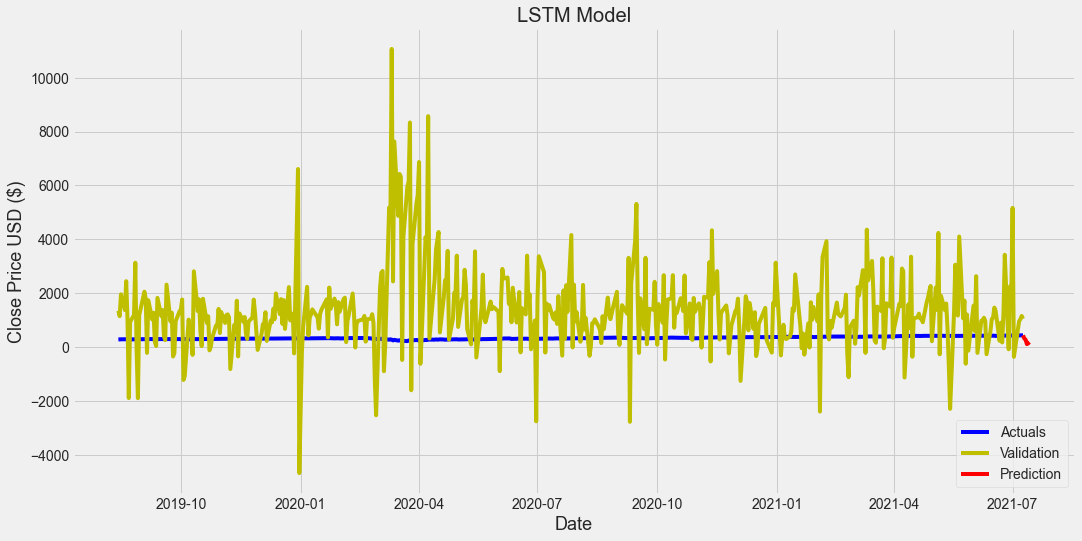

In [85]:
#stock_list = ['SPY', 'ARKG', 'LAC', 'IWC']
stock_list = ['SPY']
start = '2012-01-01'
lag = 5
for stock in stock_list:
    
    df = pull_stock(stock, start)

    train_data, test_data, X_train, y_train, train_dates, test_dates = data_prep(df=df, lag=lag)

    val_model = build_model(X_train, y_train)

    predictions, test_out = performance_model(val_model, train_data, test_data, lag=lag)

    final_pred = full_model(df=df, lag=lag)
    
    plot_model(stock, test_out, predictions, final_pred, test_dates[-1], lag=lag)